In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data augmentation for training and basic transforms for validation and test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to data
train_extract_path = '/content/drive/MyDrive/DogHeart/train/Dog_heart/Train'
validation_extract_path = '/content/drive/MyDrive/DogHeart/train/Dog_heart/Valid'

# Load datasets with transformations
train_dataset = datasets.ImageFolder(root=train_extract_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

validation_dataset = datasets.ImageFolder(root=validation_extract_path, transform=val_test_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define the Bottleneck Block
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out

# Define the ResNet-Inspired Model
class ResNetDogHeart(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetDogHeart, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define the ResNet layers
        self.layer1 = self._make_layer(64, 64, 256, blocks=3)
        self.layer2 = self._make_layer(256, 128, 512, blocks=4, stride=2)
        self.layer3 = self._make_layer(512, 256, 1024, blocks=6, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, in_channels, mid_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BottleneckBlock(in_channels, mid_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(out_channels, mid_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetDogHeart(num_classes=3).to(device)

# Custom weight initialization using Xavier initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Apply custom initialization
model.apply(initialize_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Define the training function
def train_resnet_model(model, train_loader, validation_loader, criterion, optimizer, scheduler=None, num_epochs=20, save_path="resnet_model.pt"):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy calculation
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(validation_loader)
        val_accuracy = 100 * correct / total

        # Print training and validation results
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with Validation Loss: {best_val_loss:.4f}")

        # Step scheduler
        if scheduler:
            scheduler.step(val_loss)

    print("Training complete. Best model saved.")

# Train the model
train_resnet_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs=50)


Epoch [1/50], Train Loss: 1.4531, Validation Loss: 27.1411, Validation Accuracy: 31.00%
Best model saved with Validation Loss: 27.1411
Epoch [2/50], Train Loss: 0.9765, Validation Loss: 1.0024, Validation Accuracy: 47.50%
Best model saved with Validation Loss: 1.0024
Epoch [3/50], Train Loss: 1.0288, Validation Loss: 0.8611, Validation Accuracy: 52.50%
Best model saved with Validation Loss: 0.8611
Epoch [4/50], Train Loss: 0.9421, Validation Loss: 0.9800, Validation Accuracy: 48.00%
Epoch [5/50], Train Loss: 0.8989, Validation Loss: 1.8163, Validation Accuracy: 39.50%
Epoch [6/50], Train Loss: 0.8716, Validation Loss: 0.8869, Validation Accuracy: 52.50%
Epoch [7/50], Train Loss: 0.8684, Validation Loss: 1.2711, Validation Accuracy: 34.50%
Epoch [8/50], Train Loss: 0.8746, Validation Loss: 0.9957, Validation Accuracy: 44.50%
Epoch [9/50], Train Loss: 0.8656, Validation Loss: 1.0496, Validation Accuracy: 52.50%
Epoch [10/50], Train Loss: 0.8864, Validation Loss: 1.0137, Validation Accura

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data augmentation for training and basic transforms for validation and test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to data
train_extract_path = '/content/drive/MyDrive/DogHeart/train/Dog_heart/Train'
validation_extract_path = '/content/drive/MyDrive/DogHeart/train/Dog_heart/Valid'

# Load datasets with transformations
train_dataset = datasets.ImageFolder(root=train_extract_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

validation_dataset = datasets.ImageFolder(root=validation_extract_path, transform=val_test_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define the ResNet-Inspired Model
class ResNetDogHeart(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetDogHeart, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 256, blocks=3)
        self.layer2 = self._make_layer(256, 128, 512, blocks=4, stride=2)
        self.layer3 = self._make_layer(512, 256, 1024, blocks=6, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, in_channels, mid_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BottleneckBlock(in_channels, mid_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(out_channels, mid_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetDogHeart(num_classes=3).to(device)

# Load the model weights from specified path
model_path = '/content/resnet_model.pt'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully from {}".format(model_path))
else:
    print("No model found at {}".format(model_path))
    # Initialize weights if no pretrained model
    model.apply(initialize_weights)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Define the training function
def train_resnet_model(model, train_loader, validation_loader, criterion, optimizer, scheduler=None, num_epochs=50, save_path="/content/optimized_model.pt"):
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(validation_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with Validation Loss: {best_val_loss:.4f}")

        # Step scheduler
        if scheduler:
            scheduler.step(val_loss)

    print("Training complete. Best model saved at {}".format(save_path))

# Train the model for additional 50 epochs
train_resnet_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs=50)


Model loaded successfully from /content/resnet_model.pt


<ipython-input-10-c32cbe128985>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch [1/50], Train Loss: 0.8175, Validation Loss: 1.2618, Validation Accuracy: 55.50%
Best model saved with Validation Loss: 1.2618
Epoch [2/50], Train Loss: 0.7953, Validation Loss: 0.8371, Validation Accuracy: 58.00%
Best model saved with Validation Loss: 0.8371
Epoch [3/50], Train Loss: 0.7794, Validation Loss: 1.1862, Validation Accuracy: 49.50%
Epoch [4/50], Train Loss: 0.7933, Validation Loss: 0.8574, Validation Accuracy: 57.50%
Epoch [5/50], Train Loss: 0.7799, Validation Loss: 0.8239, Validation Accuracy: 60.50%
Best model saved with Validation Loss: 0.8239
Epoch [6/50], Train Loss: 0.7892, Validation Loss: 0.7944, Validation Accuracy: 57.00%
Best model saved with Validation Loss: 0.7944
Epoch [7/50], Train Loss: 0.7419, Validation Loss: 0.8777, Validation Accuracy: 63.00%
Epoch [8/50], Train Loss: 0.7494, Validation Loss: 0.8084, Validation Accuracy: 60.50%
Epoch [9/50], Train Loss: 0.7719, Validation Loss: 0.8972, Validation Accuracy: 56.50%
Epoch [10/50], Train Loss: 0.7550

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming the model class ResNetDogHeart and the initialization function are already defined as per your previous setup

# Path to the pre-trained model
model_path = '/content/optimized_model.pt'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ResNetDogHeart(num_classes=3).to(device)

# Load the model weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Loaded model weights from:", model_path)
else:
    print("Model file not found, check the path and try again.")
    # Optionally initialize or exit
    # model.apply(initialize_weights) or exit()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training function
def train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs, save_path):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(validation_loader)
        val_accuracy = 100 * correct / total

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved better model to {save_path}")

        # Update the learning rate
        scheduler.step()

# Set path for saving the model
save_model_path = '/content/optimized_model_updated.pt'

# Call the training function
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, 50, save_model_path)


Loaded model weights from: /content/optimized_model.pt


<ipython-input-12-9b0124556217>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Epoch 1/50, Train Loss: 0.7114, Val Loss: 0.8563, Val Accuracy: 57.50%
Saved better model to /content/optimized_model_updated.pt
Epoch 2/50, Train Loss: 0.7251, Val Loss: 0.8008, Val Accuracy: 56.00%
Saved better model to /content/optimized_model_updated.pt
Epoch 3/50, Train Loss: 0.7014, Val Loss: 0.7585, Val Accuracy: 60.00%
Saved better model to /content/optimized_model_updated.pt
Epoch 4/50, Train Loss: 0.7177, Val Loss: 0.7439, Val Accuracy: 60.00%
Saved better model to /content/optimized_model_updated.pt
Epoch 5/50, Train Loss: 0.6978, Val Loss: 0.7143, Val Accuracy: 65.50%
Saved better model to /content/optimized_model_updated.pt
Epoch 6/50, Train Loss: 0.6833, Val Loss: 0.7112, Val Accuracy: 64.00%
Saved better model to /content/optimized_model_updated.pt
Epoch 7/50, Train Loss: 0.6797, Val Loss: 0.6709, Val Accuracy: 66.50%
Saved better model to /content/optimized_model_updated.pt
Epoch 8/50, Train Loss: 0.6800, Val Loss: 0.9642, Val Accuracy: 51.00%
Epoch 9/50, Train Loss: 0.

In [ ]:
import torch
import csv

def test_model(model, test_loader, output_file='test_results.csv'):
    model.eval()
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            results.extend(zip(filenames, preds.cpu().numpy()))

    if results:
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(results)
        print(f"Test results saved to {output_file}")
    else:
        print("No predictions were generated. Check if your test_loader has data.")

test_model(model, test_loader)


Test results saved to test_results.csv


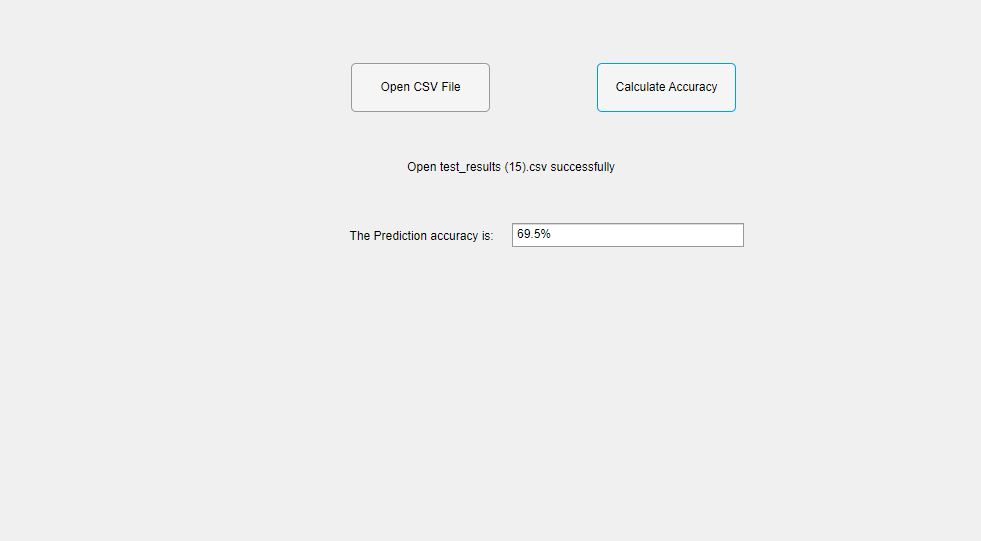

Model

In [ ]:
https://drive.google.com/file/d/1bHXGTe3xTusA-sLx2OlGcA9SLEESqqQi/view

Research Paper

In [ ]:
https://www.researchgate.net/publication/385982564_Custom_Residual_CNN_for_Multi-Class_Image_Classification_on_Dog_Heart_Data